## **Setting Things Up**

**1 If you haven't already, please hit :**

`File > Save a Copy in Drive`

**to copy this notebook to your Google drive, and work on a copy. If you don't do this, your changes won't be saved!**


**2 In order to use a GPU with your notebook, select :**

`Runtime > Change runtime type`

**menu, and then set the hardware accelerator dropdown to GPU. This can significantly speed up the training process.**

**3 In order to have enough memory with your notebook, select :**

`Runtime > Change runtime type`

**menu, and then select High-RAM in the Runtime shape dropdown.**

To facilitate your initial progress, we have included a ready-to-use code on Google Colab for this problem. It allows you to get started immediately without the need to install any software libraries. Additionally, if you prefer not to use Google Colab and prefer setting up your own programming environment or employing alternative methods, the provided files and code will still be valuable.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May  8 22:03:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 4.6 MB/s eta 0:00:00


In [ ]:
# -*-coding:utf8 -*-
import tensorflow as tf
# print("TensorFlow version:", tf.__version__)

import os

import pandas as pd
import numpy as np

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from PIL import Image

import shap

from tensorflow.python import keras
from keras.layers import Dense, Flatten, Conv2D
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import LearningRateScheduler
from keras.applications.vgg16 import VGG16
from keras import Model, Input, layers

from keras import Model, Input, layers, regularizers
from keras.models import load_model
from keras import activations

import csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Vehicle Rating Prediction/new_images_with_folder
!unzip "new_images_with_folder.zip"

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Vehicle Rating Prediction/new_interior_images_with_folder
!unzip "new_interior_images_with_folder.zip"

In [ ]:
# change to your personal project address

%cd /content/drive/MyDrive/Colab Notebooks//Vehicle Rating Prediction

/content/drive/MyDrive/Colab Notebooks/shap


## **1 Data Processing**

In [ ]:
var = "total score"
# var = "safety score"
# var = "performance score"
# var = "interior score"
# var = "critics score"

In [ ]:
# read info_data
file_name = "parametric data 2571 normalize " + var + ".csv"
info_data = pd.read_csv(file_name)
# get numpy matrix which only contains data (do not contain the title)
info_data = np.array(info_data)
print(info_data.shape)  # (2571, 310)
print(len(info_data))
print(info_data.shape[1])

In [ ]:
# train data shuffle index
num1 = 2055
idx1 = tf.range(num1)
# idx1 = tf.random.shuffle(idx1)
# print(idx1)
# print(idx1[0])
with tf.compat.v1.Session():
    index1 = idx1.numpy()
# print(index1.shape)
# print(index1[0])

# validation data shuffle index
num2 = 258
idx2 = tf.range(num2)
# idx2 = tf.random.shuffle(idx2)
# print(idx2)
# print(idx2[0])
with tf.compat.v1.Session():
    index2 = idx2.numpy()
# print(index2.shape)
# print(index2[0])

# test data shuffle index
num3 = 258
idx3 = tf.range(num3)
# idx3 = tf.random.shuffle(idx3)
# print(idx3)
# print(idx3[0])
with tf.compat.v1.Session():
    index3 = idx3.numpy()
# print(index3.shape)
# print(index3[0])

**Please take note of the image dimensions. For interior images, each image has dimensions of 300x448x3, whereas for exterior images, each image has dimensions of 290x448x3.**

In [ ]:
# assign the image data
# exterior image => 290    interior image => 300
image = np.zeros((290, 448, 3))
x_train_img = np.zeros((num1, 290, 448, 3))  # 258x224x224x3
x_validation_img = np.zeros((num2, 290, 448, 3))  # 258x224x224x3
x_test_img = np.zeros(((num3), 290, 448, 3))  # 258x224x224x3


# train data
for i in range(num1):
    folder_path = r'new_images_with_folder/' + info_data[i][1]
    dirs = os.listdir(folder_path)
    print(i)
    if len(dirs) > 0:
        # only one total picture
        dirpath = folder_path + '/' + dirs[0]
        img = Image.open(dirpath)
        img_plt = np.array(img)
        x_train_img[i, :, :, :] = img_plt / 255.0


# test data
for i in range((num3)):
    folder_path = r'new_images_with_folder/' + info_data[i+num1+num2][1]
    dirs = os.listdir(folder_path)
    print(i)
    if len(dirs) > 0:
        # only one total picture
        dirpath = folder_path + '/' + dirs[0]
        img = Image.open(dirpath)
        img_plt = np.array(img)
        x_test_img[i, :, :, :] = img_plt / 255.0


# x_train_img = tf.convert_to_tensor(x_train_img)
# x_validation_img = tf.convert_to_tensor(x_validation_img)
# x_test_img = tf.convert_to_tensor(x_test_img)
print(x_train_img.shape)
print(x_train_img[0].shape)
print(x_test_img.shape)
print(x_test_img[0].shape)
# print(x_test_img)


## **2 SHAP analysis**

**First of all, we need to load the image model.**

**When predicting total score, critics score, performance score and safety score, we only use exterior image to train the CNN model.**

**When predicting interior score, we only use interior image to train the CNN model.**

In [ ]:
# load the pretrain model
# When predicting total score, critics score, performance score and safety score, we only use exterior image to train the CNN model.
# When predicting interior score, we only use interior image to train the CNN model.

# CNN
CNNmodel = tf.keras.models.load_model('model weight/' + var + '_Ex_Img.h5')
# total score, safety score, performance score, critics score => _Ex_Img
# interior socre => _In_Img

for layer in CNNmodel.layers:
  layer._name = layer._name + "_a"
CNNmodel.summary()

In [ ]:
def f(x_test_img):
    tmp = x_test_img.copy()
    # preprocess_input(tmp)
    return CNNmodel(tmp)

In [ ]:
plt.imshow(x_test_img[30], cmap=plt.cm.binary)
plt.show()

In [ ]:
plt.imshow(x_test_img[18], cmap=plt.cm.binary)
plt.show()

**GradientExplainer which is a variant of the SHAP Explainer, was developed based on [Integrated Gradients](https://arxiv.org/abs/1703.01365) , [SHAP](https://arxiv.org/abs/1705.07874) and [SmoothGrad](https://arxiv.org/abs/1706.03825).**

In [ ]:
explainer = shap.GradientExplainer(CNNmodel,x_train_img)

## **2-1 SHAP values of the interior image regions**

**In the case of interior images, we select one specific example: the 2020 Acura RLX.**

**When calculating SHAP values, we group the individual feature values within specific areas. By obtaining the mean value, we can represent that particular area. It is beneficial to group pixels using segmentation and then calculate SHAP values at the group level. This approach enables us to determine if a specific aggregation provides informative insights or not.**

**We experimented with various grid sizes for generating the images, and the results are presented below. After conducting analysis, we determined that the 5x5 grid size is the most effective for our purposes.**


In [ ]:
shap_values = explainer.shap_values(x_test_img[30:31])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
shap_values2 = shap_values

num = 5

for i in range(59):
  for j in range(89):
    sum1 = 0
    sum2 = 0
    sum3 = 0
    for k in range(num):
      for l in range(num):
        sum1 = sum1 + shap_values[0][0][num*i+k,num*j+l,0]
        sum2 = sum2 + shap_values[0][0][num*i+k,num*j+l,1]
        sum3 = sum3 + shap_values[0][0][num*i+k,num*j+l,2]
    sum1 = sum1/(num*num)
    sum2 = sum2/(num*num)
    sum3 = sum3/(num*num)

    for k in range(num):
      for l in range(num):
        shap_values2[0][0][num*i+k,num*j+l,0] = sum1
        shap_values2[0][0][num*i+k,num*j+l,1] = sum2
        shap_values2[0][0][num*i+k,num*j+l,2] = sum3

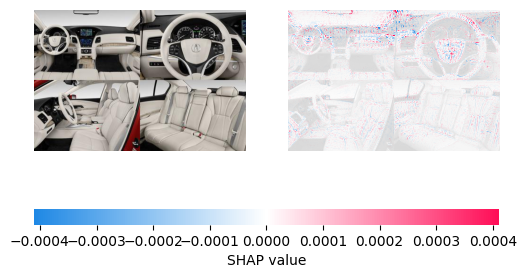

In [ ]:
shap.image_plot(shap_values, x_test_img[30:31]) # original

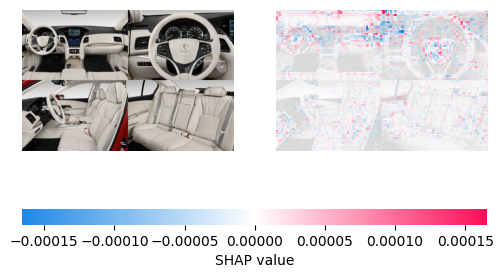

In [ ]:
shap.image_plot(shap_values1, x_test_img[30:31]) # 5x5

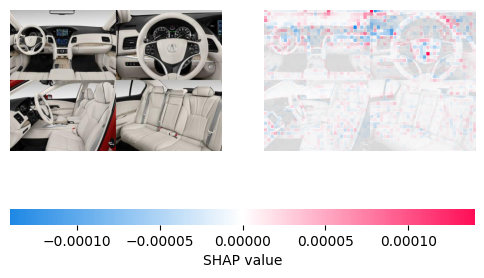

In [ ]:
shap.image_plot(shap_values2, x_test_img[30:31]) # 7x7

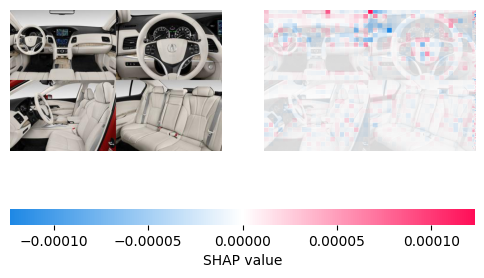

In [ ]:
shap.image_plot(shap_values1, x_test_img[30:31]) # 10x10

## **2-2 SHAP values of the exterior image regions**

**In the case of exterior images, we select one specific example: the 2020 GMC Terrain.**

**When calculating SHAP values, we group the individual feature values within specific areas. By obtaining the mean value, we can represent that particular area. It is beneficial to group pixels using segmentation and then calculate SHAP values at the group level. This approach enables us to determine if a specific aggregation provides informative insights or not.**

**We experimented with various grid sizes for generating the images, and the results are presented below. After conducting analysis, we determined that the 5x5 grid size is the most effective for our purposes.**

In [ ]:
shap_values = explainer.shap_values(x_test_img[18:19])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
shap_values6 = shap_values

num = 5

for i in range(58):
  for j in range(89):
    sum1 = 0
    sum2 = 0
    sum3 = 0
    for k in range(num):
      for l in range(num):
        sum1 = sum1 + shap_values[0][0][num*i+k,num*j+l,0]
        sum2 = sum2 + shap_values[0][0][num*i+k,num*j+l,1]
        sum3 = sum3 + shap_values[0][0][num*i+k,num*j+l,2]
    sum1 = sum1/(num*num)
    sum2 = sum2/(num*num)
    sum3 = sum3/(num*num)

    for k in range(num):
      for l in range(num):
        shap_values6[0][0][num*i+k,num*j+l,0] = sum1
        shap_values6[0][0][num*i+k,num*j+l,1] = sum2
        shap_values6[0][0][num*i+k,num*j+l,2] = sum3


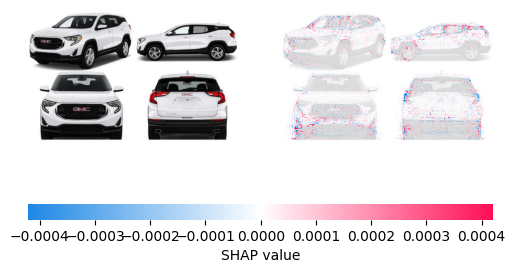

In [ ]:
shap.image_plot(shap_values, x_test_img[18:19])

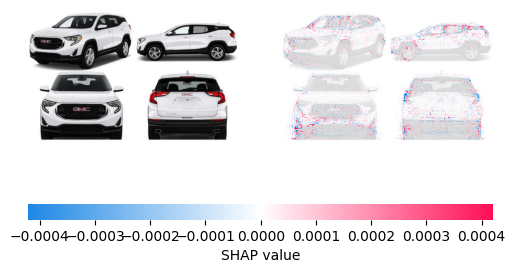

In [ ]:
shap.image_plot(shap_values5, x_test_img[18:19]) # 3x3

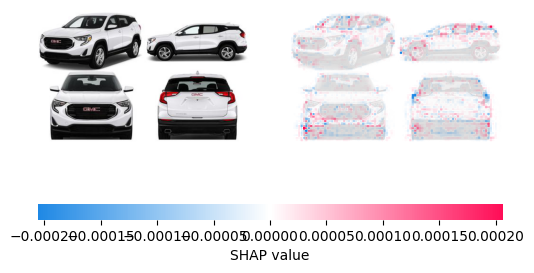

In [ ]:
shap.image_plot(shap_values6, x_test_img[18:19]) # 5x5

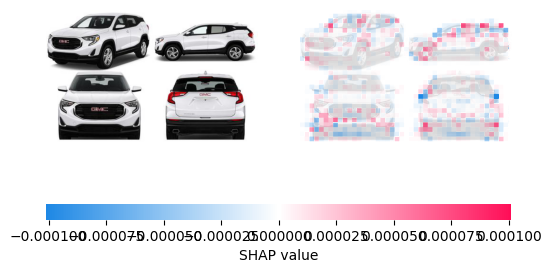

In [ ]:
shap.image_plot(shap_values1, x_test_img[18:19]) # 10x10

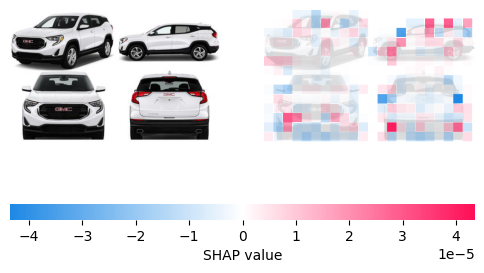

In [ ]:
shap.image_plot(shap_values3, x_test_img[18:19]) # 20x20

## **2-3 Mean absolute SHAP values of the four image regions for predicting scores**

In [ ]:
segmentation_value = np.zeros(((num3),4))

In [ ]:
print(len(x_test_img))

258


In [ ]:
for i in range(len(x_test_img)):
  shap_values = explainer.shap_values(x_test_img[i:i+1])
  SHAP_value = np.abs(shap_values[0][0]) # (290, 448, 3)
  # SHAP_value = np.abs(shap_values.values[0])

  for j in range(300):
    for k in range(448):
      if j < 150 and k < 224:
        segmentation_value[i, 0] = segmentation_value[i, 0] + SHAP_value[j][k][0] + SHAP_value[j][k][1] + SHAP_value[j][k][2]
      elif j < 150 and 224 <= k < 448:
        segmentation_value[i, 1] = segmentation_value[i, 1] + SHAP_value[j][k][0] + SHAP_value[j][k][1] + SHAP_value[j][k][2]
      elif 150 <= j < 300 and k < 224:
        segmentation_value[i, 2] = segmentation_value[i, 2] + SHAP_value[j][k][0] + SHAP_value[j][k][1] + SHAP_value[j][k][2]
      else:
        segmentation_value[i, 3] = segmentation_value[i, 3] + SHAP_value[j][k][0] + SHAP_value[j][k][1] + SHAP_value[j][k][2]

  # print(segmentation_value[i, :])


In [ ]:
avg = np.mean(segmentation_value, axis=0, keepdims=True)

In [ ]:
print(avg)

In [ ]:
# exterior image
headers = ['angular front view', 'side view', 'front view', 'rear view']

In [ ]:
# interior image
headers = ['dashboard', 'steering wheel', 'front seat', 'rear seat']

In [ ]:
with open('SHAP/SHAP_Image/'+ var + '_abs all.csv', 'w', newline='') as f:
    f_csv = csv.writer(f)
    f_csv.writerow(headers)
    f_csv.writerows(segmentation_value)

f.close()

In [ ]:
with open('SHAP/SHAP_Image/'+ var + '_abs avg.csv', 'w', newline='') as f:
    f_csv = csv.writer(f)
    f_csv.writerow(headers)
    f_csv.writerows(avg)

f.close()